### Import packages:

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from scipy.sparse import csr_matrix
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction import stop_words
from xgboost import XGBRegressor
from sklearn import grid_search
import re
#from nltk.corpus import wordnet as wn
#from nltk.corpus import wordnet_ic
#brown_ic = wordnet_ic.ic('ic-brown.dat')
from nltk.corpus import stopwords
stoplist = stopwords.words('english')
stoplist.append('till')
import nltk
import gensim
import matplotlib.pyplot as plt
from gensim import models
stem=nltk.stem.snowball.SnowballStemmer('english')

/Users/apolatovskaya/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/apolatovskaya/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Text processing

In [2]:
repl_dct={}
with open('./dicts/replaсement_dict.csv') as rd:
    for line in rd:
        line=line.strip().split(':')
        repl_dct[line[0]]=line[1]
def simple_parser(s):
    s = re.sub('&amp;', '&', s)
    s = re.sub('&nbsp;', '', s)
    s = re.sub('&#39;', '', s)
    s = s.replace("-"," ")
    s = s.replace("+"," ")
    s = re.sub(r'(?<=[a-zA-Z])\/(?=[a-zA-Z])', ' ', s)
    s = re.sub(r'(?<=\))(?=[a-zA-Z0-9])', ' ', s) # add space between parentheses and letters
    s = re.sub(r'(?<=[a-zA-Z0-9])(?=\()', ' ', s) # add space between parentheses and letters
    s = re.sub(r'(?<=[a-zA-Z][\.\,])(?=[a-zA-Z])', ' ', s) # add space after dot or colon between letters
    s = re.sub('[^a-zA-Z0-9\n\ ]', '', s)
    s = re.sub('"', '', s)
    return s

### spell corrections in search term.
def spell_correction(s):
   
    s=s.replace("ttt","tt")    
    s=s.replace("lll","ll") 
    s=s.replace("nnn","nn") 
    s=s.replace("rrr","rr") 
    s=s.replace("sss","ss") 
    s=s.replace("zzz","zz")
    s=s.replace("ccc","cc")
    s=s.replace("eee","ee")

    s=s.replace("hinges with pishinges with pins","hinges with pins")    
    s=s.replace("virtue usa","virtu usa")
    s = re.sub('outdoor(?=[a-rt-z])', 'outdoor ', s)
    s=re.sub(r'\bdim able\b',"dimmable", s) 
    s=re.sub(r'\blink able\b',"linkable", s)
    s=re.sub(r'\bm aple\b',"maple", s)
    s=s.replace("aire acondicionado", "air conditioner")
    s=s.replace("borsh in dishwasher", "bosch dishwasher")
    s=re.sub(r'\bapt size\b','appartment size', s)
    s=re.sub(r'\barm[e|o]r max\b','armormax', s)
    s=re.sub(r' ss ',' stainless steel ', s)
    s=re.sub(r'\bmay tag\b','maytag', s)
    s=re.sub(r'\bback blash\b','backsplash', s)
    s=re.sub(r'\bbum boo\b','bamboo', s)
    s=re.sub(r'(?<=[0-9] )but\b','btu', s)
    s=re.sub(r'\bcharbroi l\b','charbroil', s)
    s=re.sub(r'\bair cond[it]*\b','air conditioner', s)
    s=re.sub(r'\bscrew conn\b','screw connector', s)
    s=re.sub(r'\bblack decker\b','black and decker', s)
    s=re.sub(r'\bchristmas din\b','christmas dinosaur', s)
    s=re.sub(r'\bdoug fir\b','douglas fir', s)
    s=re.sub(r'\belephant ear\b','elephant ears', s)
    s=re.sub(r'\bt emp gauge\b','temperature gauge', s)
    s=re.sub(r'\bsika felx\b','sikaflex', s)
    s=re.sub(r'\bsquare d\b', 'squared', s)
    s=re.sub(r'\bbehring\b', 'behr', s)
    s=re.sub(r'\bcam\b', 'camera', s)
    s=re.sub(r'\bjuke box\b', 'jukebox', s)
    s=re.sub(r'\brust o leum\b', 'rust oleum', s)
    s=re.sub(r'\bx mas\b', 'christmas', s)
    s=re.sub(r'\bmeld wen\b', 'jeld wen', s)
    s=re.sub(r'\bg e\b', 'ge', s)
    s=re.sub(r'\bmirr edge\b', 'mirredge', s)
    s=re.sub(r'\bx ontrol\b', 'control', s)
    s=re.sub(r'\boutler s\b', 'outlets', s)
    s=re.sub(r'\bpeep hole', 'peephole', s)
    s=re.sub(r'\bwater pik\b', 'waterpik', s)
    s=re.sub(r'\bwaterpi k\b', 'waterpik', s)
    s=re.sub(r'\bplex[iy] glass\b', 'plexiglass', s)
    s=re.sub(r'\bsheet rock\b', 'sheetrock',s)
    s=re.sub(r'\bgen purp\b', 'general purpose',s)
    s=re.sub(r'\bquicker crete\b', 'quikrete',s)
    s=re.sub(r'\bref ridge\b', 'refrigerator',s)
    s=re.sub(r'\bshark bite\b', 'sharkbite',s)
    s=re.sub(r'\buni door\b', 'unidoor',s)
    s=re.sub(r'\bair tit\b','airtight', s)
    s=re.sub(r'\bde walt\b','dewalt', s)
    s=re.sub(r'\bwaterpi k\b','waterpik', s)
    s=re.sub(r'\bsaw za(ll|w)\b','sawzall', s)
    s=re.sub(r'\blg elec\b', 'lg', s)
    s = re.sub(r'\bhumming bird\b', 'hummingbird', s)
    s = re.sub(r'\bde ice(?=r|\b)', 'deice',s)  
    s = re.sub(r'\bliquid nail\b', 'liquid nails', s)  
    
    
    s=re.sub(r'\bdeck over\b','deckover', s)
    s=re.sub(r'\bcounter sink(?=s|\b)','countersink', s)
    s=re.sub(r'\bpipes line(?=s|\b)','pipeline', s)
    s=re.sub(r'\bbook case(?=s|\b)','bookcase', s)
    s=re.sub(r'\bwalkie talkie\b','2 pair radio', s)
    s=re.sub(r'(?<=^)ks\b', 'kwikset',s)
    s = re.sub('(?<=[0-9])[\ ]*ft(?=[a-z])', 'ft ', s)
    s = re.sub('(?<=[0-9])[\ ]*mm(?=[a-z])', 'mm ', s)
    s = re.sub('(?<=[0-9])[\ ]*cm(?=[a-z])', 'cm ', s)
    s = re.sub('(?<=[0-9])[\ ]*inch(es)*(?=[a-z])', 'in ', s)
    
    s = re.sub(r'(?<=[1-9]) pac\b', 'pack', s)
 
    s = re.sub(r'\bcfl bulbs\b', 'cfl light bulbs', s)
    s = re.sub(r' cfl(?=$)', ' cfl light bulb', s)
    s = re.sub(r'candelabra cfl 4 pack', 'candelabra cfl light bulb 4 pack', s)
    s = re.sub(r'\bthhn(?=$|\ [0-9]|\ [a-rtuvx-z])', 'thhn wire', s)
    s = re.sub(r'\bplay ground\b', 'playground',s)
    s = re.sub(r'\bemt\b', 'emt electrical metallic tube',s)
    s = re.sub(r'\boutdoor dining se\b', 'outdoor dining set',s)
          
    if "a/c" in s:
        if ('unit' in s) or ('frost' in s) or ('duct' in s) or ('filt' in s) or ('vent' in s) or ('clean' in s) or ('vent' in s) or ('portab' in s):
            s=s.replace("a/c","air conditioner")
        else:
            s=s.replace("a/c","ac")
    for word in repl_dct.keys():
        s=re.sub(r'\b'+word+r'\b',repl_dct[word], s)
    return s

In [3]:
def replace_in_parser(s):
    #the first three shared on forum
    s=s.replace("acccessories","accessories")
    s = re.sub(r'\bscott\b', 'scotts', s) #brand
    s = re.sub(r'\borgainzer\b', 'organizer', s)
    s = s.replace("craftsm,an","craftsman")        
    s = re.sub(r'depot.com/search=', '', s)
    s = re.sub(r'pilers,needlenose', 'pliers, needle nose', s)
    s = re.sub(r'\bmr.', 'mr ', s)
    s = re.sub(r'&amp;', '&', s)
    s = re.sub('&nbsp;', '', s)
    s = re.sub('&#39;', '', s)
    s = re.sub(r'(?<=[0-9]),[\ ]*(?=[0-9])', '', s)
    s = s.replace(";",".")
    s = s.replace(",",".")
    s = s.replace(":",". ")
    s = s.replace("+"," ")
    s = re.sub(r'\bU.S.', 'US ', s)
    s = s.replace(" W x "," ")
    s = s.replace(" H x "," ")
    s = re.sub(' [\#]\d+[\-\d]*[\,]*', '', s)    
    s = re.sub('(?<=[0-9\%])(?=[A-Z][a-z])', '. ', s) # add dot between number and cap letter
    s = re.sub(r'(?<=\))(?=[a-zA-Z0-9])', ' ', s) # add space between parentheses and letters
    s = re.sub(r'(?<=[a-zA-Z0-9])(?=\()', ' ', s) # add space between parentheses and letters


    s = re.sub(r'\aluminuum\b', 'aluminum', s)    
    s = re.sub(r'\bgeneral electric','ge', s)
    s = s.replace("adaptor","adapter")
    s = re.sub(r'\bfibre', 'fiber', s)
    s = re.sub(r'\bbuilt in\b', 'builtin',s)
    s = re.sub(r'\bshark bite\b', 'sharkbite',s)
    s = re.sub('barbeque', 'barbecue',s)
    s = re.sub(r'\bbbq\b', 'barbecue', s)
    s = re.sub(r'\bbathroom[s]*\b', 'bath', s)
    s = re.sub(r'\bberkeley\b', 'berkley', s)
    s = re.sub(r'\bbookshelves\b', 'book shelf', s)
    s = re.sub(r'\bbookshelf\b', 'book shelf', s)
    s = re.sub(r'\bin line ', ' inline ', s)
    s = re.sub(r'round up\b', ' roundup', s)
    s = re.sub(r'\blg electronics\b', 'lg', s)
    s = re.sub(r'\bhdtv\b', 'hd tv', s)
    s = re.sub(r'black [and ]*decker', 'black and decker', s)
    s = re.sub(r'backer board[s]*', 'backerboard', s)
    s = re.sub(r'\bphillips\b', 'philips', s)
    s = re.sub(r'\bshower head[s]*\b', 'showerhead', s)
    s = re.sub(r'\bbull nose\b', 'bullnose', s)
    s = re.sub(r'\bflood light\b', 'floodlight', s)
    s = re.sub(r'\barrester\b', 'arrestor', s)
    s = re.sub(r'\bbi fold\b', 'bifold', s)
    s = re.sub(r'\bfirepit[s]*\b', 'fire pit', s)
    s = re.sub(r'\bbed bug[s]*\b', 'bedbug', s)
    s = re.sub(r'\bhook up[s]*\b', 'hookup', s)
    s = re.sub(r'\bjig saw[s]*\b', 'jigsaw', s)
    s = re.sub(r'\bspacesav(?=er[s]*|ing)', 'space sav', s)
    s = re.sub(r'\bwall paper', 'wallpaper', s)
    s = re.sub(r'\bphotocell', 'photo cells', s)
    s = re.sub(r'\bplasti dip\b', 'plastidip', s)
    s = re.sub(r'\bflexi dip\b', 'flexidip', s)  
    s = re.sub(r'\bback splash','backsplash', s)
    s = re.sub(r'\bbarstool(?=\b|s)','bar stool', s)
    s = re.sub(r'\blampholder(?=\b|s)','lamp holder', s)
    s = re.sub(r'\brainsuit(?=\b|s)','rain suit', s)
    s = re.sub(r'\bback up\b','backup', s)
    s = re.sub(r'\bwheel barrow', 'wheelbarrow', s)
    s=re.sub(r'\bsaw horse', 'sawhorse',s)
    s=re.sub(r'\bscrew driver', 'screwdriver',s)
    s=re.sub(r'\bnut driver', 'nutdriver',s)
    s=re.sub(r'\bflushmount', 'flush mount',s)
    s=re.sub(r'\bcooktop(?=\b|s\b)', 'cook top',s)
    s=re.sub(r'\bcounter top(?=s|\b)','countertop', s)    
    s=re.sub(r'\bbacksplash', 'back splash',s)
    s=re.sub(r'\bhandleset', 'handle set',s)
    s=re.sub(r'\bplayset', 'play set',s)
    s=re.sub(r'\bsidesplash', 'side splash',s)
    s=re.sub(r'\bdownlight', 'down light',s)
    s=re.sub(r'\bbackerboard', 'backer board',s)
    s=re.sub(r'\bshoplight', 'shop light',s)
    s=re.sub(r'\bdownspout', 'down spout',s)
    s=re.sub(r'\bpowerhead', 'power head',s)
    s=re.sub(r'\bnightstand', 'night stand',s)
    s=re.sub(r'\bmicro fiber[s]*\b', 'microfiber', s)
    s=re.sub(r'\bworklight', 'work light',s)
    s=re.sub(r'\blockset', 'lock set',s)
    s=re.sub(r'\bslatwall', 'slat wall',s)
    s=re.sub(r'\btileboard', 'tile board',s)
    s=re.sub(r'\bmoulding', 'molding',s)
    s=re.sub(r'\bdoorstop', 'door stop',s)
    s=re.sub(r'\bwork bench\b','workbench', s)
    s=re.sub(r'\bweed[\ ]*eater','weed trimmer', s)
    s=re.sub(r'\bweed[\ ]*w[h]*acker','weed trimmer', s)
    s=re.sub(r'\bnightlight(?=\b|s)','night light', s)
    s=re.sub(r'\bheadlamp(?=\b|s)','head lamp', s)
    s=re.sub(r'\bfiber board','fiberboard', s)
    s=re.sub(r'\bmail box','mailbox', s)
    
    replace_material_dict={'aluminium': 'aluminum', 
    'medium density fiberboard': 'mdf',
    'high density fiberboard': 'hdf',
    'fiber reinforced polymer': 'frp',
    'cross linked polyethylene': 'pex',
    'poly vinyl chloride': 'pvc', 
    'thermoplastic rubber': 'tpr', 
    'poly lactic acid': 'pla', 
    'acrylonitrile butadiene styrene': 'abs',
    'chlorinated poly vinyl chloride': 'cpvc'}
    for word in replace_material_dict.keys():
        if word in s:
            s = s.replace(word, replace_material_dict[word])
    for word in repl_dct.keys():
        if word in s:
            s = s.replace(word, repl_dct[word])
    
    return s
def clean_material(s):
    replace_dict={'Medium Density Fiberboard (MDF)':'mdf', 'High Density Fiberboard (HDF)':'hdf',\
    'Fibre Reinforced Polymer (FRP)': 'frp', 'Acrylonitrile Butadiene Styrene (ABS)': 'abs',\
    'Cross-Linked Polyethylene (PEX)':'pex', 'Chlorinated Poly Vinyl Chloride (CPVC)': 'cpvc',\
    'PVC (vinyl)': 'pvc','Thermoplastic rubber (TPR)':'tpr','Poly Lactic Acid (PLA)': 'pla',\
    '100% Polyester':'polyester','100% UV Olefin':'olefin', '100% BCF Polypropylene': 'polypropylene',\
    '100% PVC':'pvc'}        
    if s in replace_dict.keys():
        s=replace_dict[s]
    return s

### Loading train and test data and merging it:

In [4]:
train=pd.read_csv('train.csv', index_col=0, header=0,encoding="ISO-8859-1")
test=pd.read_csv('test.csv', index_col=0, header=0,encoding="ISO-8859-1")
print(train.columns)
print(test.columns)
data = pd.concat((train, test), axis=0, ignore_index=True)
data.head()

Index(['product_uid', 'product_title', 'search_term', 'relevance'], dtype='object')
Index(['product_uid', 'product_title', 'search_term'], dtype='object')


,product_title,product_uid,relevance,search_term
0,Simpson Strong-Tie 12-Gauge Angle,100001,3.00,angle bracket
1,Simpson Strong-Tie 12-Gauge Angle,100001,2.50,l bracket
2,BEHR Premium Textured DeckOver 1-gal. SC-141 T...,100002,3.00,deck over
3,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,100005,2.33,rain shower head
4,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,100005,2.67,shower only faucet


### Cleaning and correction search_term

In [5]:
google_dict={}
with open ('./dicts/google_dict.csv') as gd:
    for line in gd:
        line=line.strip().split(':')
        google_dict[line[0]]=line[1]
data['search_term']=data['search_term'].apply(lambda x: google_dict[x] if x in google_dict.keys() else x)
data['search_term']=data['search_term'].apply(lambda x: simple_parser(x))
data['search_term']=data['search_term'].apply(lambda x: spell_correction(x))

### Loading attributes information. Brand and material and bullet information:

In [6]:
func={}
brands={}
materials={}
with open('attributes.csv', 'r') as file:
    for f in file:
        f=f.strip().split(',')
        if "Bullet" in f[1]:
            if f[0] in func.keys():
                func[f[0]]+=' '+f[2]
            else:
                func[f[0]]=f[2]
        if "MFG Brand Name" in f[1]:
            if f[0] in brands.keys():
                brands[f[0]]+=' '+f[2]
            else:
                brands[f[0]]=f[2]
        if "Material" in f[1]:
            if f[0] in materials.keys():
                materials[f[0]]+=' '+f[2]
            else:
                materials[f[0]]=f[2]
functionality = pd.Series(func, name='Functionality')
brand=pd.Series(brands, name='Brand')
material=pd.Series(materials, name='Material')
functionality.index.name ='product_uid'
brand.index.name ='product_uid'
material.index.name ='product_uid'
functionality=functionality.reset_index()
brand=brand.reset_index()
material=material.reset_index()
functionality['product_uid']=functionality['product_uid'].apply(lambda x: int(x))
brand['product_uid']=brand['product_uid'].apply(lambda x: int(x))
material['product_uid']=material['product_uid'].apply(lambda x: int(x))

### Merging all data (train-test set, attributes and product description information):

In [7]:
proddescription=pd.read_csv('product_descriptions.csv',header=0)
data= pd.merge(data, proddescription, how='left', on='product_uid')
data= pd.merge(data, material, how='left', on='product_uid')
data= pd.merge(data, brand, how='left', on='product_uid')
data= pd.merge(data, functionality, how='left', on='product_uid')

### Cleaning attributes, product description and title

In [8]:
%%time
brand_dct={}
with open ('./dicts/brand_dict.csv') as bd:
    for line in bd:
        line=line.strip().split(':')
        brand_dct[line[0]]=line[1]
def brand_clean(s):
    for b in brand_dct.keys():
        s=s.replace(b,brand_dct[b])
    return s
data['Brand']=data['Brand'].apply(lambda x: x[1:-1].lower() if type(x)==str else x)
data['Material']=data['Material'].apply(lambda x: x[1:-1] if type(x)==str else x)
data['Material']=data['Material'].apply(lambda x: clean_material(x).lower() if type(x)==str else x)
data['Functionality']=data['Functionality'].apply(lambda x: x[1:-1] if type(x)==str else x)
data['Brand']=data['Brand'].apply(lambda x: brand_dct[x] if x in brand_dct.keys() else x)
data['product_title']=data['product_title'].apply(lambda x: simple_parser(x.lower()))
data['product_description']=data['product_description'].apply(lambda x: simple_parser(x.lower()) if type(x)==str else x)
data['Functionality']=data['Functionality'].apply(lambda x: simple_parser(x.lower()) if type(x)==str else x)
data['product_title']=data['product_title'].apply(lambda x: replace_in_parser(x.lower()))
data['product_description']=data['product_description'].apply(lambda x: replace_in_parser(x.lower()) if type(x)==str else x)
data['Functionality']=data['Functionality'].apply(lambda x: replace_in_parser(x.lower()) if type(x)==str else x)

CPU times: user 11min 3s, sys: 1.95 s, total: 11min 5s
Wall time: 11min 6s


### Stemming and removing stop words in product_title, search_term, product_description, material, brand

In [9]:
data.Material.fillna('',inplace=True)
data.Brand.fillna('',inplace=True)
data.Functionality.fillna('',inplace=True)

In [10]:
%%time
stop_words = ['for', 'and', 'in', 'on','with','what','from','that','less']
def spellch(x):
    for word in x:
        if word in stop_words:
            x.remove(word)
    return x
data['search_term']=data['search_term'].apply(lambda x: spellch(x))
for col in ['product_title','product_description','Functionality']:
    data[col]=data[col].apply(lambda x: ' '.join([item for item in x.split(' ') if item not in stoplist]) if type(x)==str else x)
    print('!')

!
!
!
CPU times: user 1min 41s, sys: 141 ms, total: 1min 41s
Wall time: 1min 41s


In [11]:
%%time
for col in ['product_title','search_term','product_description','Material','Brand','Functionality']:
    data[col]=data[col].apply(lambda x: " ".join([stem.stem(str(word)) for word in x.split(" ")]) if type(x)==str else x)

CPU times: user 10min 35s, sys: 378 ms, total: 10min 36s
Wall time: 10min 36s


### Creating variables

In [12]:
for col in ['product_title','search_term','product_description','Material','Brand','Functionality']:
    data[col+'_ug']=data[col].apply(lambda x: x.split())
lst1=[]
sp=['search_term_ug','product_title_ug','product_description_ug','Functionality_ug','Brand_ug','Material_ug']
for l in range(len(data['search_term'])):
    q=[]
    for j in sp:
        q+=data.loc[l,j]
    lst1.append(q)

### Creating word2vec model and calculating similarity between search_term and another fields

In [13]:
%%time
model1 = gensim.models.Word2Vec(lst1, sg=1, window=10, sample=1e-5, negative=5, size=300)

CPU times: user 23min 5s, sys: 3.23 s, total: 23min 8s
Wall time: 7min 52s


In [14]:
%%time
sp=['search_term_ug','product_title_ug','product_description_ug','Functionality_ug','Brand_ug','Material_ug']
n_similarity=list()
st=data['search_term_ug']
for s in sp[1:]:
    target=data[s]
    lst=list()
    for i in range(len(st)):
        w1=st[i]
        w2=target[i]
        d1=[]
        d2=[]
        for j in range(len(w1)):
            if w1[j] in model1.wv.vocab:
                d1.append(w1[j])
        for j in range(len(w2)):
            if w2[j] in model1.wv.vocab:
                d2.append(w2[j])
        if d1==[] or d2==[]:
            lst.append(0)
        else:    
            lst.append(model1.n_similarity(d1,d2))
    n_similarity.append(lst)

CPU times: user 2min 58s, sys: 343 ms, total: 2min 59s
Wall time: 2min 59s


In [15]:
var=['product_uid','len_st']
for j in range(len(n_similarity)):   
    data["word2vec_"+str(sp[j+1])]=n_similarity[j]
    var.append("word2vec_"+str(sp[j+1]))

In [16]:
def DistJaccard(str1, str2):
    str1 = set(str1.split())
    str2 = set(str2.split())
    return float(len(str1 & str2)) / len(str1 | str2)
for i in ['product_title','product_description','Brand','Functionality']:
    var.append('DJ_st_'+i)
    data['DJ_st_'+i]=data[['search_term', i]].apply(lambda x: DistJaccard(x[0],x[1]) if type(x[1])==str else 0, axis=1)

In [17]:
%%time
for col in ['product_title','product_description','Material']:
    #,'Brand','Functionality']:
    data['st_full_in_'+col]=data[['search_term', col]].apply(lambda x: len([w for w in x[0].split() if w in x[1].split()]) if type(x[1])==str else 0, axis=1)
    data['st_unique_in_'+col]=data[['search_term', col]].apply(lambda x: len(set([w for w in x[0].split() if w in x[1].split()])) if type(x[1])==str else 0, axis=1)
    print('!')
    var.append('st_full_in_'+col)
    var.append('st_unique_in_'+col)
data['len_st']=data.search_term.apply(lambda x: len(x.split()))

!
!
!
CPU times: user 1min 56s, sys: 216 ms, total: 1min 56s
Wall time: 1min 57s


In [18]:
%%time
data['ratio_st_full_in_product_title']=data[['st_full_in_product_title','product_title_ug']].apply(lambda x: x[0]/len(x[1]), axis=1)
var.append('ratio_st_full_in_product_title')
data['ratio_st_unique_in_product_title']=data[['st_unique_in_product_title','product_title_ug']].apply(lambda x: x[0]/len(x[1]), axis=1)
var.append('ratio_st_unique_in_product_title')
print('!')
data['ratio_st_full_in_product_description']=data[['st_full_in_product_description','product_description_ug']].apply(lambda x: x[0]/len(x[1]), axis=1)
var.append('ratio_st_full_in_product_description')
data['ratio_st_unique_in_product_description']=data[['st_unique_in_product_description','product_description_ug']].apply(lambda x: x[0]/len(x[1]), axis=1)
var.append('ratio_st_unique_in_product_description')
print('!')
data['ratio_st_full_in_Material']=data[['st_full_in_Material','Material_ug']].apply(lambda x: x[0]/len(x[1]) if len(x[1])>0 else 0, axis=1)
var.append('ratio_st_full_in_Material')
#data['ratio_st_unique_in_Material']=data[['st_unique_in_Material','Material_ug']].apply(lambda x: x[0]/len(x[1]) if len(x[1])>0 else 0, axis=1)
#var.append('ratio_st_unique_in_Material')

#data['ratio_st_full_in_Functionality']=data[['st_full_in_Functionality','Functionality_ug']].apply(lambda x: x[0]/len(x[1]) if len(x[1])>0 else 0, axis=1)
#var.append('ratio_st_full_in_Functionality')
#data['ratio_st_unique_in_Functionality']=data[['st_unique_in_Functionality','Functionality_ug']].apply(lambda x: x[0]/len(x[1])if len(x[1])>0 else 0, axis=1)
#var.append('ratio_st_unique_in_Functionality')

#data['ratio_st_full_in_Brand']=data[['st_full_in_Brand','Brand_ug']].apply(lambda x: x[0]/len(x[1]) if len(x[1])>0 else 0, axis=1)
#var.append('ratio_st_full_in_Brand')
#data['ratio_st_unique_in_Brand']=data[['st_unique_in_Brand','Brand_ug']].apply(lambda x: x[0]/len(x[1]) if len(x[1])>0 else 0, axis=1)
#var.append('ratio_st_unique_in_Brand')


!
!
CPU times: user 38.2 s, sys: 157 ms, total: 38.4 s
Wall time: 38.5 s


In [19]:
%%time
#var=list(set(var))
st_dct={}
ds=data.search_term
for i in list(set(ds)):
    st_dct[i]=len(ds[ds==i])
print('!')
data['st_cnt']=data['search_term'].apply(lambda x: st_dct[x])
var

!
CPU times: user 9min 6s, sys: 1.27 s, total: 9min 7s
Wall time: 9min 7s


## TF-IDF features

In [20]:
tfvt=TfidfVectorizer(stop_words='english')
tfvd=TfidfVectorizer(stop_words='english')
tfvf=TfidfVectorizer(stop_words='english')

title_feats = tfvt.fit_transform(list(set(list(data['product_title'])))) 
descr_feats = tfvd.fit_transform(list(set(list(data['product_description'])))) 
functy_feats = tfvf.fit_transform(list(set(list(data['Functionality'])))) 

tfidft = tfvt.transform(data['search_term']) 
tfidfd = tfvd.transform(data['search_term']) 
tfidff = tfvf.transform(data['search_term']) 

In [21]:
l1=np.ones((len(tfvt.get_feature_names()),1))
l2=np.ones((len(tfvd.get_feature_names()),1))
l3=np.ones((len(tfvf.get_feature_names()),1))
data['tfidf_pt']=tfidft.tocsr().dot(l1)
data['tfidf_pd']=tfidfd.tocsr().dot(l2)
data['tfidf_f']=tfidff.tocsr().dot(l3)
var.append('tfidf_pt')
var.append('tfidf_pd')
var.append('tfidf_f')

In [39]:
var.append('st_cnt')

In [40]:
lentr=train.shape[0]
data_train=data[:lentr]
data_test=data[lentr:]
X_train=data_train[var]
Y_train=data_train['relevance']
X_test=data_test[var]

In [41]:
#estimator = RandomForestRegressor(random_state=0)
xgbr=XGBRegressor(seed=0, learning_rate=0.1,objective='reg:linear')
estimator=xgbr
#BaggingRegressor(xgbr,random_state=2017)
#estimator.fit(X_train,Y_train)
estimator.get_params().keys()

dict_keys(['base_score', 'colsample_bylevel', 'colsample_bytree', 'gamma', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'n_estimators', 'nthread', 'objective', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'seed', 'silent', 'subsample'])

In [42]:
%%time
params_grid = {
    'max_depth':[3,4,5],
    #'base_estimator__n_estimators':[10,20,50,70,90],
    'n_estimators' : [165,170,175],
    #'n_estimators':[2,3,5,10]
}
grid = grid_search.GridSearchCV(estimator, params_grid, scoring = 'neg_mean_squared_error', cv = 3)
grid.fit(X_train,Y_train)
print(grid.best_score_)
print(grid.best_estimator_)

-0.21599807760578782
XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=165, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
CPU times: user 3min 58s, sys: 1.66 s, total: 4min
Wall time: 4min 2s


In [43]:
estimator=grid.best_estimator_
y_test=estimator.predict(X_test)
test['relevance']=y_test

### Importance of features

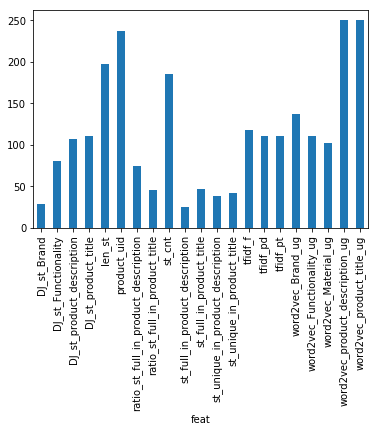

In [44]:
sp = estimator.booster().get_score(importance_type='weight')
a=pd.Series(sp, name='imp')
a.index.name='feat'
a.plot(kind='bar')
plt.show()

In [45]:
test[['relevance']].to_csv('res.csv')

### Final score is 0.46530